# Grid search

A typical use case of `pythonradex` is to compute a grid of models to infer the physical conditions corresponding to some observed flux. Here we provide an example of such a use case.

## How to optimise performance

**To improve performance when iterating over a grid of parameters, it is very important to use the `update_parameters` method, rather than initialising a new `Source` object at each iteration step.** This is because initialising a `Source` object is computationally expensive.

To further optimise performance, in the loop over the parameters, it is recommended to put collider density and kinetic temperature in the outermost loop because updating them is more expensive compared to e.g. the column density. For example, if you want to explore a grid of kinetic temperature and column density, your code could look something like this:
```
for Tkin in Tkin_grid:
    for N in column_density_grid:
        source.update_parameters(N=N,Tkin=Tkin)
        source.solve_radiative_transfer()
        #store the results of the calculation...
```
In this example, the updates of the kinetic temperature are minimised (note that `update_parameters` only updates the kinetic temperature if it really changed). The performance gain from the optimised loop structure might be minimal though. The most important point remains to use `update_parameters` rather than initialising a new `Source` object at each iteration step.

## Scenario

Assume we measured the CO 3-2 flux from a source as $(2.8\pm0.4)\times 10^{-24}$ W/m$^2$. Further assume, for simplicity, that we know the kinetic temperature of the gas, that the source can be modelled as a static slab, and that the intrinsic line width is 1 km/s. We want to estimate the CO column density and the hydrogen density compatible with the observed flux. For simplicity, we assume a thermal ortho/para ratio of H$_2$ of 3. We assume that the source has a known solid angle of (10x10 au$^2$)/(100 pc)$^2$.

## Setup

In [1]:
from pythonradex import radiative_transfer, helpers
import numpy as np
from scipy import constants
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
datafilepath = "./co.dat"
geometry = "static slab"
line_profile_type = "Gaussian"
width_v = 1 * constants.kilo

# initialise the source
source = radiative_transfer.Source(
    datafilepath=datafilepath,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
    warn_negative_tau=False,
)

## Run the model grid

In [3]:
# fixed parameters:
ext_background = helpers.generate_CMB_background(z=0)
# assume the kinetic temperature and solid angle are known
Tkin = 50
solid_angle = (10 * constants.au) ** 2 / (100 * constants.parsec) ** 2

# parameters to explore:
# explore column densities between 1e12 and 1e17 cm-2:
N_values = np.logspace(12, 17, 60) / constants.centi**2
# explore H2 densities between 100 and 1e6 cm-3
H2_densities = np.logspace(1, 6, 50) / constants.centi**3

# we are only interested in the flux of CO 3-2, which has index 2 (since it is the 3rd transition listed in co.dat)
transitions = 2


def get_collider_densities(H2_density):
    # assume thermal ortho/para = 3:
    return {"para-H2": H2_density / 4, "ortho-H2": 3 * H2_density / 4}


# make the initial update of the parameters to fix the constant parameters
# we consider models without dust
# the values for N and collider_densities are not important here, since they will
# be updated in the loop
source.update_parameters(
    N=N_values[0],
    Tkin=Tkin,
    collider_densities=get_collider_densities(H2_densities[0]),
    ext_background=ext_background,
    T_dust=0,
    tau_dust=0,
)

Next, let's iterate over the grid and store the flux values:

In [4]:
# we will collect the model fluxes in a 2D array:
output_CO32_flux = np.empty((H2_densities.size, N_values.size))

# now iterate over the grid and store the flux values
# we put H2 density in the outermost loop, but for this specific
# example, it turns out there is no performance gain by doing that
for i, H2_density in enumerate(H2_densities):
    collider_densities = get_collider_densities(H2_density=H2_density)
    for j, N in enumerate(N_values):
        source.update_parameters(N=N, collider_densities=collider_densities)
        source.solve_radiative_transfer()
        flux = source.frequency_integrated_emission(
            output_type="flux", transitions=transitions, solid_angle=solid_angle
        )
        output_CO32_flux[i, j] = flux

## Analysis

Now we can examine the CO 3-2 flux as a function of H$_2$ density and column density, and compare to the observed flux.

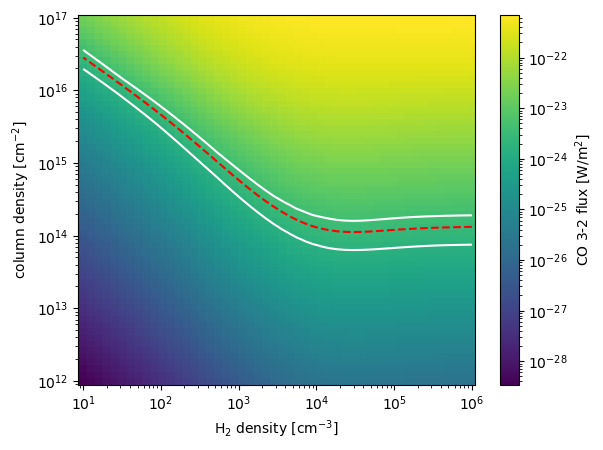

In [5]:
H2_DENSITIES, N_VALUES = np.meshgrid(H2_densities, N_values, indexing="ij")
fig, ax = plt.subplots()
# plot the log of the model flux for better visualisation
im = ax.pcolormesh(
    H2_DENSITIES / constants.centi**-3,
    N_VALUES / constants.centi**-2,
    output_CO32_flux,
    norm=LogNorm(vmin=output_CO32_flux.min(), vmax=output_CO32_flux.max())
)
fig.colorbar(im, label="CO 3-2 flux [W/m$^2$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"H$_2$ density [cm$^{-3}$]")
ax.set_ylabel(r"column density [cm$^{-2}$]")
ax.axis("tight")

measured_flux = 2.8e-24
measurement_error = 0.4e-24
sigma = np.abs((output_CO32_flux - measured_flux) / measurement_error)
# contour at the measured flux:
ax.contour(
    H2_DENSITIES / constants.centi**-3,
    N_VALUES / constants.centi**-2,
    np.log10(output_CO32_flux),
    levels=[
        np.log10(measured_flux),
    ],
    colors="red",
)
# contours at +- 3 sigma:
ax.contour(
    H2_DENSITIES / constants.centi**-3,
    N_VALUES / constants.centi**-2,
    np.log10(sigma),
    levels=np.log10(
        [
            3,
        ]
    ),
    colors="white",
)

We see that above a H$_2$ density of ${\sim}10^4$ cm$^{-3}$, the flux becomes independent of the H$_2$ density, which means the emission is in LTE. If LTE applies, the observed emission can be explained by a column density of ${\sim}10^{14}$ cm$^{-2}$. The measurement can also be explained by a higher column densitities of up to a few times $10^{16}$ cm$^{-2}$ if we consider H$_2$ densities as low as 10 cm$^{-3}$.